In [55]:
import pandas as pd
import joblib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import custom_functions as fn
# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)
# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import layers, optimizers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from sklearn import set_config
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from tensorflow.keras.models import Sequential

set_config(transform_output='pandas')
pd.set_option('display.max_colwidth', 250)

In [53]:
def evaluate_classification_network(model,
                                    X_train=None, y_train=None,
                                    X_test=None, y_test=None,
                                    history=None, history_figsize=(6,6),
                                    figsize=(6,4), normalize='true',
                                    output_dict = False,
                                    cmap_train='Blues',
                                    cmap_test="Reds",
                                    values_format=".2f",
                                    colorbar=False):
    """Evaluates a neural network classification task using either
    separate X and y arrays or a tensorflow Dataset

    Data Args:
        X_train (array, or Dataset)
        y_train (array, or None if using a Dataset
        X_test (array, or Dataset)
        y_test (array, or None if using a Dataset)
        history (history object)
        """
    # Plot history, if provided
    if history is not None:
        plot_history(history, figsize=history_figsize)
    ## Adding a Print Header
    print("\n"+'='*80)
    print('- Evaluating Network...')
    print('='*80)
    ## TRAINING DATA EVALUATION
    # check if X_train was provided
    if X_train is not None:
        ## Check if X_train is a dataset
        if hasattr(X_train,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_train, y_train_pred = get_true_pred_labels(model, X_train)
        else:
            # Get predictions for training data
            y_train_pred = model.predict(X_train)
        ## Pass both y-vars through helper compatibility function
        y_train = convert_y_to_sklearn_classes(y_train)
        y_train_pred = convert_y_to_sklearn_classes(y_train_pred)

        # Call the helper function to obtain regression metrics for training data
        results_train = classification_metrics(y_train, y_train_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_train,
                                               values_format=values_format,
                                         label='Training Data')

        ## Run model.evaluate
        print("\n- Evaluating Training Data:")
        print(model.evaluate(X_train, return_dict=True))

    # If no X_train, then save empty list for results_train
    else:
        results_train = []
    ## TEST DATA EVALUATION
    # check if X_test was provided
    if X_test is not None:
        ## Check if X_train is a dataset
        if hasattr(X_test,'map'):
            # If it IS a Datset:
            # extract y_train and y_train_pred with helper function
            y_test, y_test_pred = get_true_pred_labels(model, X_test)
        else:
            # Get predictions for training data
            y_test_pred = model.predict(X_test)
        ## Pass both y-vars through helper compatibility function
        y_test = convert_y_to_sklearn_classes(y_test)
        y_test_pred = convert_y_to_sklearn_classes(y_test_pred)

        # Call the helper function to obtain regression metrics for training data
        results_test = classification_metrics(y_test, y_test_pred,
                                         output_dict=True, figsize=figsize,
                                             colorbar=colorbar, cmap=cmap_test,
                                              values_format=values_format,
                                         label='Test Data')

        ## Run model.evaluate
        print("\n- Evaluating Test Data:")
        print(model.evaluate(X_test, return_dict=True))

    # If no X_test, then save empty list for results_test
    else:
        results_test = []

    # Store results in a dictionary
    results_dict = {'train':results_train,
                    'test': results_test}
    if output_dict == True:
        return results_dict

In [2]:
df = pd.read_csv('/content/ratings_model.csv')
df.head(2)

,review_id,movie_id,imdb_id,original_title,review,rating,tokens,target,Tokenized,Lemmatized,Tokens-joined,Lemmas-joined
0,57086ff5c3a3681d29001512,7443,tt0120630,Chicken Run,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",9.0,"A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",High-rating,"['A', 'guilty', 'pleasure', 'for', 'me', 'personally,', 'as', 'I', 'love', 'both', ""'The"", 'Great', ""Escape'"", 'and', 'most', 'of', 'the', 'works', 'I', 'have', 'seen,', 'over', 'the', 'years,', 'from', 'this', 'rightfully-esteemed', 'British', '...","['guilty', 'pleasure', 'personally', 'love', 'the', 'Great', 'Escape', 'of', 'the', 'work', 'see', 'the', 'year', 'rightfully', 'esteem', 'british', 'animation', 'company', 'highly', 'recommend', 'child', 'adult', 'enjoy', 'animation']","A guilty pleasure for me personally, as I love both 'The Great Escape' and most of the works I have seen, over the years, from this rightfully-esteemed British animation company. Highly recommended both for children and for adults who enjoy anima...",guilty pleasure personally love the Great Escape of the work see the year rightfully esteem british animation company highly recommend child adult enjoy animation
1,57b2d23dc3a36837d7000b14,955,tt0120755,Mission: Impossible II,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully...",3.0,"The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully...",Low-rating,"['The', 'first', 'underwhelmed', 'me,', 'but', 'this', 'one', 'straight-up', 'bored', 'me.', 'Again,', 'of', 'course', 'seeing', 'Hunt', 'climb', 'a', 'mountain', 'without', 'a', 'harness', 'is', 'impressive', 'sure.', 'And', 'I', 'even', 'quite'...","['the', 'underwhelme', 'straight', 'bore', 'of', 'course', 'see', 'Hunt', 'climb', 'mountain', 'harness', 'be', 'impressive', 'sure', 'like', 'the', 'idea', 'the', 'villain', 'of', 'the', 'piece', 'angle', 'woefully', 'underdeveloped', '\r\n\r\n'...","The first underwhelmed me, but this one straight-up bored me. Again, of course seeing Hunt climb a mountain without a harness is impressive sure. And I even quite liked the idea behind the villain of the piece (though even that angle was woefully...",the underwhelme straight bore of course see Hunt climb mountain harness be impressive sure like the idea the villain of the piece angle woefully underdeveloped \r\n\r\n set in predominantly Australia to grab attention say cause pretty biased come...


In [3]:
df['rating'].isnull().sum()

0

In [4]:
X = df['review'].values
y= df['target'].values

In [5]:
encoder = LabelEncoder()
y = pd.Series(encoder.fit_transform(y))
y.value_counts()

1    1224
0    1195
Name: count, dtype: int64

In [6]:
# Convert to Dataset object
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
# shuffling the data once
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [8]:
# Determing how many samples for each split
# Calculate the number of samples for training
split_train = 0.7
n_train_samples =  int(len(ds) * split_train)
print(f"Use {n_train_samples} samples as training data")
# Calculate the number of samples for validation
split_val = 0.2
n_val_samples = int(len(ds) * split_val)
print(f"Use {n_val_samples} samples as validation data")
# Test size is remainder
split_test = 1 - (split_train + split_val)
print(f"The remaining {len(ds)- (n_train_samples+n_val_samples)} samples will be used as test data.")

Use 1693 samples as training data
Use 483 samples as validation data
The remaining 243 samples will be used as test data.


In [9]:
# Use .take to slice out the number of samples for training
train_ds = ds.take(n_train_samples)
# Skipover the training batches
val_ds = ds.skip(n_train_samples)
# Take .take to slice out the correct number of samples for validation
val_ds = val_ds.take(n_val_samples)
# Skip over all of the training + validation samples, the rest remain as samples for testing
test_ds = ds.skip(n_train_samples + n_val_samples)

In [10]:
## Shuffling just the training data
train_ds  = train_ds.shuffle(buffer_size = len(train_ds))

In [11]:
#  Setting the batch_size for all datasets
BATCH_SIZE = 1
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 1693 training batches.
 There are 483 validation batches.
 There are 243 testing batches.


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test, random_state=42)

In [13]:
# Data Inspection

example_X, example_y= train_ds.take(1).get_single_element()
print(example_X)
print(example_y)

tf.Tensor([b'We have yet another movie where it is getting high praise for reasons of politics...and possibly because Jamie Lee Curtis is back...but mainly for politics.\r\n\r\nBut it was really nice seeing Jamie Lee Curtis back, and nice in the "it doesn\'t really feel like a Halloween movie without her in it" kind of way.\r\n\r\nUnfortunately that isn\'t enough to save the film, nor is the added over-the-top blood and gore that didn\'t really need a place in the first two movies.\r\n\r\nBut...the blood and gore seemed to replace real scares (though there were a couple) as if to say, yeah, they understand that they aren\'t making this horror movie frightening, so they might as well make it bloodier and hope that it\'s a decent trade off for actual scares.\r\n\r\nThe main issue, however, is that it is spread thin. It\'s like it was written in committee where everyone that there little plot be added to the film despite how difficult that would make actual story telling.\r\n\r\nThe resul

In [14]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)
# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(1,), dtype=string, numpy=
array([b"A kid is getting other kids to play poker online. The head of the university doesn't like it and threaten to throw him out. The kid (Justin Timberlake) takes all his money and play some poker, hoping that he will win and his future secure. Well, you guessed it, he loses everything. But, not because he is bad or anything, no, there is this guy called Ivan (Ben Affleck) who runs these online casinos, and who cheats the poor young kids.\r\n\r\nNow there is only one sensible thing to do, which is to go to Costa Rica and confront the bad guy with his scheme. Thats exactly what I would do. Well, nah, not really, but I hope you see where I am going with this. He arrives in Costa Rica, and soon finds himself at the deep end of the pool, hunted by Ivan, some dude named Herrera and the FBI... of course.\r\n\r\nThe plot is idiotic, as you might have guessed. It makes no sense, and the poor actors don't know how to act. And honestly, I don't bl

In [15]:
# Text vectorization layer

In [16]:
# Create the TextVectorization layer
count_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="count"
)

In [17]:
# Before training, only contains the out of vocab token ([UNK])
count_vectorizer.get_vocabulary()

['[UNK]']

In [18]:
# Fit the layer on the training texts
count_vectorizer.adapt(ds_texts)

In [19]:
# Getting list of vocab
vocab = count_vectorizer.get_vocabulary()
# Exploring list of vocab
type(vocab), len(vocab), vocab[:6]

(list, 24922, ['[UNK]', 'the', 'and', 'a', 'of', 'to'])

In [20]:
# The first value will be the count of all of the words not in the vocobulary
counts= count_vectorizer(['python python python python is the most amazing thing in the world for data science!'])
counts

<tf.Tensor: shape=(1, 24922), dtype=float32, numpy=array([[0., 2., 0., ..., 0., 0., 0.]], dtype=float32)>

In [21]:
# TFIDF Vectorizer

In [22]:
# Create Text Vectorization Layer
tfidf_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="tf_idf",
)
# Build the vectorizer vocabulary
tfidf_vectorizer.adapt(ds_texts)
# Confrim vocabulary size
tfidf_vectorizer.vocabulary_size()

24922

In [23]:
# The first value will be the score of all of the words not in the vocobulary
tfidf= tfidf_vectorizer(['python python python python is the most amazing thing in the world for data science!'])
tfidf

<tf.Tensor: shape=(1, 24922), dtype=float32, numpy=
array([[0.       , 1.4785116, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)>

In [24]:
# Sequence Vectorizer≥

In [25]:
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=30
)
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()

24923

In [26]:
# Obtain the sequence of sample text with the sequence_vectorizer
sequence= sequence_vectorizer(['python python python python is the most amazing thing in the world for data science!'])
sequence

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[16469, 16469, 16469, 16469,     7,     2,    74,   392,   148,
            9,     2,   143,    16, 22305,   952,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]])>

In [27]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'and',
 4: 'a',
 5: 'of',
 6: 'to',
 7: 'is',
 8: 'it',
 9: 'in',
 10: 'that',
 11: 'i',
 12: 'this',
 13: 'but',
 14: 'was',
 15: 'with',
 16: 'for',
 17: 'as',
 18: 'movie',
 19: 'film',
 20: 'not',
 21: 'are',
 22: 'its',
 23: 'on',
 24: 'be',
 25: 'you',
 26: 'one',
 27: 'have',
 28: 'his',
 29: 'an',
 30: 'so',
 31: 'all',
 32: 'like',
 33: 'from',
 34: 'he',
 35: 'at',
 36: 'by',
 37: 'just',
 38: 'they',
 39: 'if',
 40: 'about',
 41: 'or',
 42: 'what',
 43: 'more',
 44: 'story',
 45: 'has',
 46: 'there',
 47: 'some',
 48: 'even',
 49: 'who',
 50: 'my',
 51: 'good',
 52: 'really',
 53: 'me',
 54: 'out',
 55: 'very',
 56: 'time',
 57: 'when',
 58: 'no',
 59: 'which',
 60: 'we',
 61: 'only',
 62: 'well',
 63: 'their',
 64: 'had',
 65: 'much',
 66: 'can',
 67: 'up',
 68: 'than',
 69: 'would',
 70: 'also',
 71: 'because',
 72: 'great',
 73: 'way',
 74: 'most',
 75: 'do',
 76: 'into',
 77: 'her',
 78: 'characters',
 79: 'will',
 80: 'were',
 81: 'ho

In [28]:
# Set up Pipeline to allow GridSearching different vectorizers
vect_pipe = Pipeline([('vectorizer', CountVectorizer()), # This is just a placeholder
                     ('clf',MultinomialNB())])

In [29]:
# Define a param grid with options for the vectorizer
param_grid = {
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'clf__alpha': [.5, 1]
}

In [30]:
# Create grid search
grid_search = GridSearchCV(vect_pipe, param_grid, cv=3, verbose=1, n_jobs=-1)

In [31]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'clf__alpha': [0.5, 1],
                         'vectorizer': [CountVectorizer(), TfidfVectorizer()]},
             verbose=1)

**Deep NLP Models**

In [32]:
encoder = LabelEncoder()

y = pd.Series(encoder.fit_transform(y))
y.value_counts()

1    1224
0    1195
Name: count, dtype: int64

In [33]:
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [34]:
ds = ds.shuffle(buffer_size=len(ds), reshuffle_each_iteration=False)

In [35]:
split_train = 0.7
n_train_samples =  int(len(ds) * split_train)
print(f"Use {n_train_samples} samples as training data")

split_val = 0.2
n_val_samples = int(len(ds) * split_val)
print(f"Use {n_val_samples} samples as validation data")

split_test = 1 - (split_train + split_val)
print(f"The remaining {len(ds)- (n_train_samples+n_val_samples)} samples will be used as test data.")

Use 1693 samples as training data
Use 483 samples as validation data
The remaining 243 samples will be used as test data.


In [36]:
train_ds = ds.take(n_train_samples)
val_ds = ds.skip(n_train_samples)
val_ds = val_ds.take(n_val_samples)
test_ds = ds.skip(n_train_samples + n_val_samples)

In [37]:
train_ds  = train_ds.shuffle(buffer_size = len(train_ds))

In [38]:
BATCH_SIZE = 1
train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 1693 training batches.
 There are 483 validation batches.
 There are 243 testing batches.


In [39]:
# Inspect the data

In [40]:
example_X, example_y= train_ds.take(1).get_single_element()
print(example_X)
print(example_y)

tf.Tensor([b"Oh man, if I'd at any point ever had any faith at all in _A Wrinkle in Time_? I would have been **sorely** disappointed. Which is a shame on both counts, because it would be great if a film targeted at young people with both complex ideas **and** multiple women of colour in lead roles could have been like... Good.\r\n\r\n_Final rating:\xe2\x98\x85\xc2\xbd: - Boring/disappointing. Avoid where possible._"], shape=(1,), dtype=string)
tf.Tensor([1], shape=(1,), dtype=int64)


In [41]:
count_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="count")

In [42]:
count_vectorizer.get_vocabulary()

['[UNK]']

In [43]:
count_vectorizer.adapt(ds_texts)

In [44]:
vocab = count_vectorizer.get_vocabulary()

type(vocab), len(vocab), vocab[:6]

(list, 24922, ['[UNK]', 'the', 'and', 'a', 'of', 'to'])

In [45]:
# Text Vectorization Layer
tfidf_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="tf_idf",
)
# Vectorizer vocab
tfidf_vectorizer.adapt(ds_texts)
# Confrim vocab size
tfidf_vectorizer.vocabulary_size()

24922

In [46]:
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

24923

In [47]:
EMBED_DIM = 100

In [48]:
SEQUENCE_LENGTH = 400

In [49]:
classes = y.unique()
classes

array([0, 1])

In [50]:
def build_lstm_model(text_vectorization_layer):

    lstm_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM,
                                  input_length=SEQUENCE_LENGTH)
        ])

    lstm_model.add(layers.LSTM(128))
    lstm_model.add(layers.Dense(len(classes), activation='softmax'))

    lstm_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    lstm_model.summary()
    return lstm_model

In [51]:
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 30)                0         
 Vectorization)                                                  
                                                                 
 embedding_2 (Embedding)     (None, 30, 100)           2492300   
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 2609806 (9.96 MB)
Trainable params: 2609806 (9.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2
1693/1693 [==============================] - 91s 52ms/step - loss: 0.811

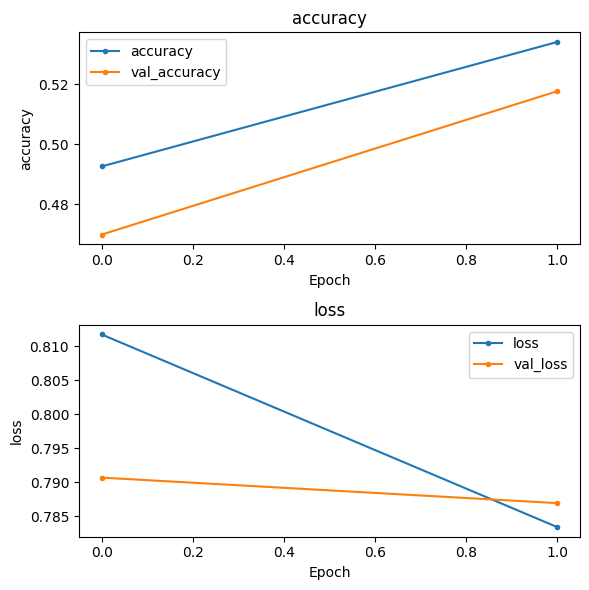


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       848
           1       0.60      0.62      0.61       845

    accuracy                           0.61      1693
   macro avg       0.61      0.61      0.61      1693
weighted avg       0.61      0.61      0.61      1693



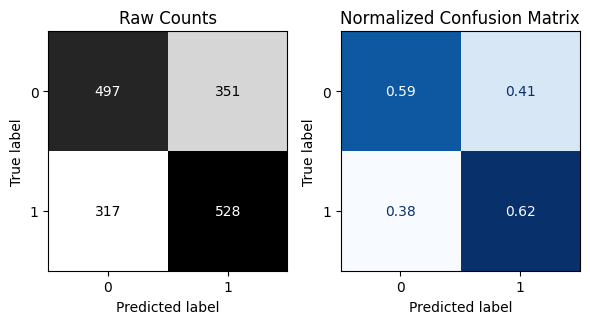


- Evaluating Training Data:
1693/1693 [==============================] - 12s 7ms/step - loss: 0.6952 - accuracy: 0.6054
{'loss': 0.6952289938926697, 'accuracy': 0.6054341197013855}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.58      0.48      0.52       127
           1       0.52      0.61      0.56       116

    accuracy                           0.54       243
   macro avg       0.55      0.55      0.54       243
weighted avg       0.55      0.54      0.54       243



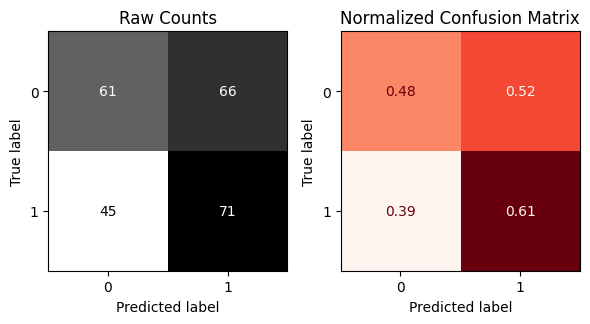


- Evaluating Test Data:
243/243 [==============================] - 2s 7ms/step - loss: 0.8187 - accuracy: 0.5432
{'loss': 0.8186584115028381, 'accuracy': 0.5432098507881165}


In [56]:
# lstm model
lstm_model = build_lstm_model(sequence_vectorizer)

EPOCHS = 2

history = lstm_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

results = fn.evaluate_classification_network(
    lstm_model, X_train=train_ds,
    X_test=test_ds, history=history
);

In [59]:
import json
with open('config/filepaths.json') as f:
    FPATHS = json.load(f)
FPATHS

FileNotFoundError: [Errno 2] No such file or directory: 'config/filepaths.json'

In [57]:
rf_path = FPATHS['models']['lstm_model']
rf_path

NameError: name 'FPATHS' is not defined

In [ ]:
# Save random forest model in a file using path from the dictionary
joblib.dump(lstm_model, rf_path)